# Project 2 Djikstra's Algorithm


In [1]:
import numpy as np
import pandas as pd
import random
import time
import networkx as nx
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
def generate(n, w, p):
    ret = nx.fast_gnp_random_graph(n, p, seed=777)
    for (u, v) in ret.edges():
        ret.edges[u,v]['weight'] = random.randint(1, w)
    return ret

In [3]:
def plot_graph(G):
    pos = nx.spring_layout(G, seed=555)
    weights = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_color='red')
    plt.title("Generated Graph with Weights")
    plt.show()

In [4]:
graph = []
graph.append(generate(10, 10, 0.4))
graph.append(generate(10, 10, 0.5))
graph.append(generate(15, 100, 0.4))
graph.append(generate(15, 100, 0.5))
graph.append(generate(100, 100, 0.5))
graph.append(generate(1000, 100, 0.5))

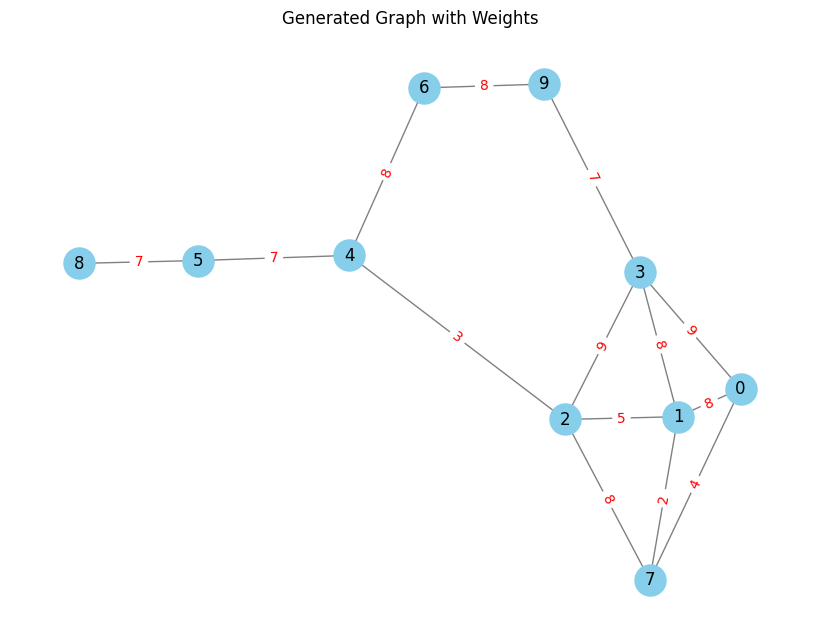

In [5]:
plot_graph(graph[0])

In [6]:
def to_adj_matrix(G):
    return nx.to_numpy_array(G, dtype=int)

In [7]:
to_adj_matrix(graph[0])

array([[0, 8, 0, 9, 0, 0, 0, 4, 0, 0],
       [8, 0, 5, 8, 0, 0, 0, 2, 0, 0],
       [0, 5, 0, 9, 3, 0, 0, 8, 0, 0],
       [9, 8, 9, 0, 0, 0, 0, 0, 0, 7],
       [0, 0, 3, 0, 0, 7, 8, 0, 0, 0],
       [0, 0, 0, 0, 7, 0, 0, 0, 7, 0],
       [0, 0, 0, 0, 8, 0, 0, 0, 0, 8],
       [4, 2, 8, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 7, 0, 0, 0, 0],
       [0, 0, 0, 7, 0, 0, 8, 0, 0, 0]])

## A. Adj Matrix and Array
Suppose the input graph G = (V, E) is stored in an adjacency matrix and we
use an array for the priority queue. 

Implement the Dijkstra’s algorithm using this
setting and analyze its time complexity with respect to |V| and |E| both
theoretically and empirically.

In [8]:
# Djikstra for part 1a
# Assume it is stored in an adj matrix, assuming V nodes, size of adj matrix is V x V

def dijkstra_1a(adj_matrix, source):
    # measures distance from that 
    V = len(adj_matrix)
    distances = [float('inf') for i in range(V)] 
    
    # distance from root to itself is 0
    distances[source] = 0
    visited = set()
    while len(visited) != V:
        # first we extract cheapest node
        min_node = -1
        distance = float('inf')
        for i in range(V):
            if i not in visited and distances[i] < distance:
                min_node = i
                distance = distances[i]
        
        if min_node == -1:
            return distances
        
        visited.add(min_node)
        for i in range(V):
            if adj_matrix[min_node][i] != 0 and i not in visited:
                distances[i] = min(distances[i], distances[min_node] + adj_matrix[min_node][i])
    return distances

source = 0
print(dijkstra_1a(to_adj_matrix(graph[0]), source))

[0, np.int64(6), np.int64(11), np.int64(9), np.int64(14), np.int64(21), np.int64(22), np.int64(4), np.int64(28), np.int64(16)]


In [9]:
# theoretical time complexity is clearly O(V^2) as each time we extract the cheapest node, we add the node to visited and check the rest of the nodes
# and we need to do this V times
# and each time, we look through the array of distances of size V
# empirical time complexity is as follows
sizes = [10 ** i for i in range(1, 5)]
runtimes = []

for size in sizes:
    g = generate(size, 1000, 0.3)
    source = 0
    start_time = time.perf_counter()
    dijkstra_1a(to_adj_matrix(g), source)
    end_time = time.perf_counter()
    runtimes.append(end_time - start_time)

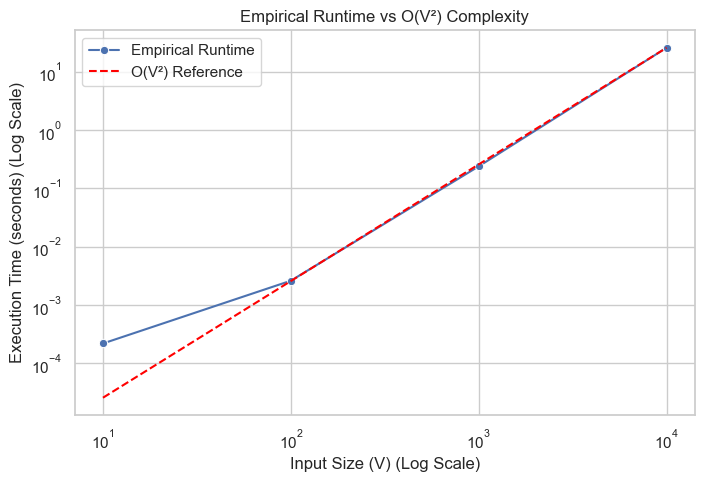

In [10]:
# Convert to Pandas DataFrame
df = pd.DataFrame({'Input Size': sizes, 'Runtime (seconds)': runtimes})

# Plot empirical data
sb.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sb.lineplot(x='Input Size', y='Runtime (seconds)', marker='o', data=df, label="Empirical Runtime")

# Overlay a theoretical O(V^2) curve
V_squared = np.array(sizes) ** 2
scaling_factor = runtimes[-1] / V_squared[-1]  # Normalize to match empirical data
plt.plot(sizes, scaling_factor * V_squared, linestyle="--", color="red", label="O(V²) Reference")

# Log scale for better visualization (optional)
plt.xscale("log")
plt.yscale("log")  # Log-log scale highlights polynomial growth

# Labels and title
plt.xlabel("Input Size (V) (Log Scale)")
plt.ylabel("Execution Time (seconds) (Log Scale)")
plt.title("Empirical Runtime vs O(V²) Complexity")
plt.legend()

# Show plot
plt.show()

## B. Adj List and Heap

In [11]:
def adj_matrix_to_list(adj_matrix):
    adj_list = {}
    V = len(adj_matrix)  # Number of vertices

    for i in range(V):
        adj_list[i] = []
        for j in range(V):
            if adj_matrix[i][j] != 0:  # Non-zero means there is an edge
                adj_list[i].append((j, adj_matrix[i][j]))  # (neighbor, weight)
    
    return adj_list

In [12]:
import heapq

def djikstra_1b(adj_list, source):
    pq = []
    heapq.heapify(pq)
    heapq.heappush(pq, (0, source))
    distances = [float('inf') for i in range(len(adj_list))]
    distances[source] = 0
    while len(pq) != 0:
        # get 
        distance, node = heapq.heappop(pq)
        for neighbour, weight in adj_list[node]:
            if distances[neighbour] > distance + weight:
                distances[neighbour] = distance + weight
                heapq.heappush(pq, (distances[neighbour], neighbour))
    return distances

adj_list = adj_matrix_to_list(to_adj_matrix(graph[0]))

djikstra_1b(adj_list, source)

[0,
 np.int64(6),
 np.int64(11),
 np.int64(9),
 np.int64(14),
 np.int64(21),
 np.int64(22),
 np.int64(4),
 np.int64(28),
 np.int64(16)]

In [13]:
# Theoretical Complexity is O((V+E)logV))